# Portfolio Risk Management Analysis with yfinance
This notebook performs comprehensive risk analysis for a stock portfolio including:

### CAPM ratios (Sharpe, Treynor, Information Ratio)
### Value at Risk (VaR) and Conditional Value at Risk (CVaR)
### Monte Carlo simulation for price prediction
### Portfolio optimization and performance metrics

In [51]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Set plotting style
print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

sns.set_palette("husl")

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# Configuration and Portfolio Setup

In [63]:
# Portfolio Configuration in DOLLAR VALUES
PORTFOLIO_DOLLARS = {
    'NVDA': 25000,   # Nvidia - $25,000
    'PYPL': 25000,   # PayPal - $25,000
    'MSFT': 20000,  # Microsoft - $20,000
    'KO': 20000,   # Amazon - $20,000
    'JPM': 10000   # JP Morgan - $10,000
}

# Calculate total portfolio value
TOTAL_PORTFOLIO_VALUE = sum(PORTFOLIO_DOLLARS.values())

# Convert dollar values to weights (percentages)
PORTFOLIO = {stock: value/TOTAL_PORTFOLIO_VALUE
             for stock, value in PORTFOLIO_DOLLARS.items()}

# Market benchmark
MARKET_SYMBOL = 'SPY'  # S&P 500 ETF as market proxy

# Analysis Parameters (keep these the same)
RISK_FREE_RATE = 0.05  # 5% annual risk-free rate
CONFIDENCE_LEVELS = [0.95, 0.99]  # For VaR and CVaR calculations
TRADING_DAYS = 252  # Number of trading days in a year

# Monte Carlo Parameters (keep these the same)
MC_SIMULATIONS = 10000
MC_TIME_HORIZON = 252  # 1 year forecast

# Data Parameters (keep these the same)
START_DATE = '2021-01-01'
END_DATE = '2024-01-01'

print(f"Total Portfolio Value: ${TOTAL_PORTFOLIO_VALUE:,.2f}")
print(f"\nPortfolio Allocation:")
for stock, dollars in PORTFOLIO_DOLLARS.items():
    print(f"{stock:8} ${dollars:>10,.2f} ({PORTFOLIO[stock]:>6.1%})")
print(f"\nSum of weights: {sum(PORTFOLIO.values()):.2f}")

Total Portfolio Value: $100,000.00

Portfolio Allocation:
NVDA     $ 25,000.00 ( 25.0%)
PYPL     $ 25,000.00 ( 25.0%)
MSFT     $ 20,000.00 ( 20.0%)
KO       $ 20,000.00 ( 20.0%)
JPM      $ 10,000.00 ( 10.0%)

Sum of weights: 1.00


# Data Acquisition Using yfinance


In [64]:
# Note: If yfinance is experiencing issues, see the alternative in the next cell
print("Fetching data using yfinance...")

# Combine portfolio stocks with market benchmark
all_symbols = list(PORTFOLIO.keys()) + [MARKET_SYMBOL]

# Download all data at once
stock_data = yf.download(all_symbols, start=START_DATE, end=END_DATE, progress=True)

# Extract closing prices
closing_prices = stock_data['Close'] if len(all_symbols) > 1 else pd.DataFrame({all_symbols[0]: stock_data['Close']})

print(f"\nData shape: {closing_prices.shape}")
print(f"Date range: {closing_prices.index[0]} to {closing_prices.index[-1]}")

[*********************100%***********************]  6 of 6 completed

Fetching data using yfinance...

Data shape: (753, 6)
Date range: 2021-01-04 00:00:00 to 2023-12-29 00:00:00


# Data Preprocessing and Returns Calculation

In [65]:
# Calculate daily returns
returns = closing_prices.pct_change().dropna()

# Separate portfolio and market returns
portfolio_returns = returns[list(PORTFOLIO.keys())]
market_returns = returns[MARKET_SYMBOL]

# Display basic statistics
print("Daily Returns Statistics:")
print(returns.describe())

Daily Returns Statistics:
Ticker         JPM          KO        MSFT        NVDA        PYPL         SPY
count   752.000000  752.000000  752.000000  752.000000  752.000000  752.000000
mean      0.000631    0.000321    0.000916    0.002320   -0.001352    0.000458
std       0.015343    0.010194    0.017534    0.033388    0.028467    0.011085
min      -0.061464   -0.069626   -0.077156   -0.094726   -0.245904   -0.043483
25%      -0.008215   -0.005156   -0.008672   -0.017107   -0.016700   -0.005590
50%       0.000713    0.000791    0.000662    0.002563   -0.000418    0.000459
75%       0.009368    0.006047    0.011268    0.020866    0.012894    0.007022
max       0.075510    0.038671    0.082268    0.243696    0.121755    0.054954


# Portfolio Performance Metrics


In [66]:
# Calculate portfolio returns based on weights
weights = np.array(list(PORTFOLIO.values()))
portfolio_return_series = (portfolio_returns * weights).sum(axis=1)

# Basic statistics
annualized_return = portfolio_return_series.mean() * TRADING_DAYS
annualized_volatility = portfolio_return_series.std() * np.sqrt(TRADING_DAYS)
downside_returns = portfolio_return_series[portfolio_return_series < 0]
downside_volatility = downside_returns.std() * np.sqrt(TRADING_DAYS)

print("Portfolio Performance Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Downside Volatility: {downside_volatility:.2%}")

Portfolio Performance Metrics:
Annualized Return: 13.92%
Annualized Volatility: 27.50%
Downside Volatility: 17.50%


# CAPM Metrics Calculation


In [67]:
def calculate_capm_metrics(portfolio_returns, market_returns, risk_free_rate):
    """
    Calculate all CAPM-related metrics
    """
    # Annualized metrics
    portfolio_return = portfolio_returns.mean() * TRADING_DAYS
    market_return = market_returns.mean() * TRADING_DAYS
    portfolio_std = portfolio_returns.std() * np.sqrt(TRADING_DAYS)

    # Calculate beta
    covariance = np.cov(portfolio_returns, market_returns)[0, 1]
    market_variance = market_returns.var()
    beta = covariance / market_variance

    # Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std

    # Treynor Ratio
    treynor_ratio = (portfolio_return - risk_free_rate) / beta

    # Jensen's Alpha
    alpha = portfolio_return - (risk_free_rate + beta * (market_return - risk_free_rate))

    # Information Ratio
    tracking_error = (portfolio_returns - market_returns).std() * np.sqrt(TRADING_DAYS)
    information_ratio = (portfolio_return - market_return) / tracking_error

    # Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(TRADING_DAYS)
    sortino_ratio = (portfolio_return - risk_free_rate) / downside_std

    return {
        'Beta': beta,
        'Sharpe Ratio': sharpe_ratio,
        'Treynor Ratio': treynor_ratio,
        'Jensen\'s Alpha': alpha,
        'Information Ratio': information_ratio,
        'Sortino Ratio': sortino_ratio
    }

# Calculate CAPM metrics
capm_metrics = calculate_capm_metrics(portfolio_return_series, market_returns, RISK_FREE_RATE)

print("\nCAPM Metrics:")
print("-" * 40)
for metric, value in capm_metrics.items():
    print(f"{metric}: {value:.3f}")


CAPM Metrics:
----------------------------------------
Beta: 1.368
Sharpe Ratio: 0.324
Treynor Ratio: 0.065
Jensen's Alpha: -0.000
Information Ratio: 0.161
Sortino Ratio: 0.510


# Value at Risk (VaR) and CVaR Calculations


Value at Risk (VaR) and Conditional Value at Risk (CVaR)
Confidence VaR Hist (Daily) VaR Param (Daily) CVaR (Daily) VaR Hist (Annual) VaR Param (Annual) CVaR (Annual)
       95%            2.79%             2.79%        3.67%            44.35%             44.36%        58.30%
       99%            4.46%             3.98%        4.95%            70.88%             63.10%        78.53%

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------

For 95% confidence level:
- VaR = 2.79% daily (44.35% annually)
  → "We are 95% confident our daily loss won't exceed 2.79%"

- CVaR = 3.67% daily (58.30% annually)
  → "If we hit the worst 5% of days, average loss will be 3.67%"



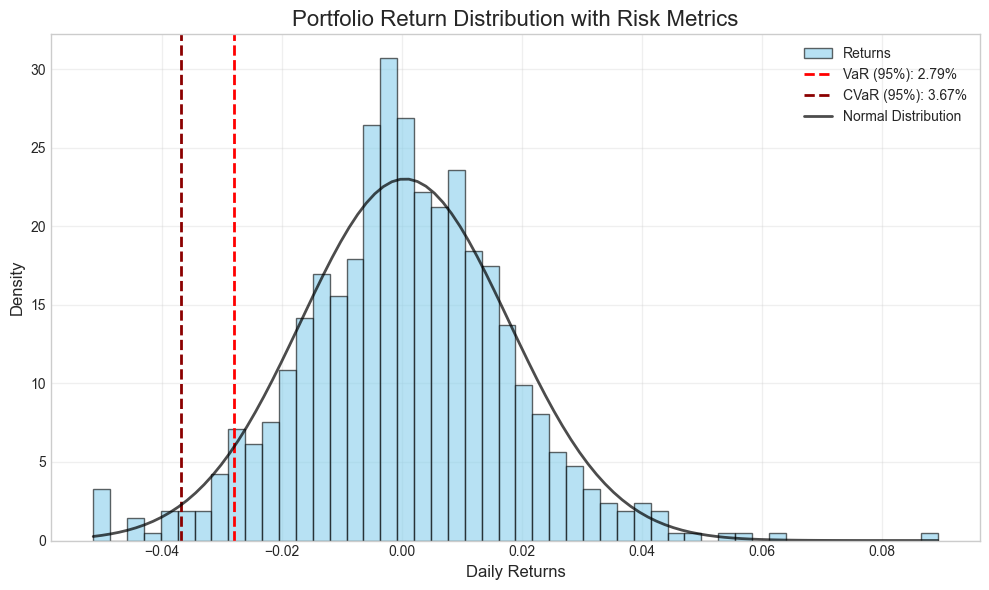

In [68]:
# --- Risk Functions ---------------------------------------

def calculate_var_historical(returns, confidence_level):
    """
    Historical VaR - Returns positive value for losses

    Example: If worst 5% of returns is -2%, VaR = 2% (positive)
    """
    percentile = (1 - confidence_level) * 100
    return -np.percentile(returns, percentile)

def calculate_var_parametric(returns, confidence_level):
    """
    Parametric VaR - Assumes normal distribution

    Uses formula: VaR = -(mean - z_score * std)
    """
    mean = returns.mean()
    std = returns.std()
    z_score = stats.norm.ppf(confidence_level)
    return -(mean - z_score * std)

def calculate_cvar(returns, confidence_level):
    """
    CVaR (Expected Shortfall) - Average loss beyond VaR

    Answers: "If things go really bad, how bad on average?"
    """
    # Find the VaR threshold
    var_threshold = np.percentile(returns, (1 - confidence_level) * 100)

    # Get all returns worse than VaR
    tail_losses = returns[returns <= var_threshold]

    # Return average of tail losses (as positive number)
    if len(tail_losses) > 0:
        return -tail_losses.mean()
    else:
        return -var_threshold

# --- Parameters --------------------------------------------------------------
CONFIDENCE_LEVELS = [0.95, 0.99]
TRADING_DAYS = 252

# --- Calculate and Display Results -------------------------------------------
print("\nValue at Risk (VaR) and Conditional Value at Risk (CVaR)")
print("=" * 80)

# Store results for better formatting
results = []

for conf_level in CONFIDENCE_LEVELS:
    # Calculate daily metrics
    var_hist = calculate_var_historical(portfolio_return_series, conf_level)
    var_param = calculate_var_parametric(portfolio_return_series, conf_level)
    cvar = calculate_cvar(portfolio_return_series, conf_level)

    # Annualize (square root of time rule)
    annual_factor = np.sqrt(TRADING_DAYS)
    annual_var_hist = var_hist * annual_factor
    annual_var_param = var_param * annual_factor
    annual_cvar = cvar * annual_factor

    results.append({
        'Confidence': f"{conf_level:.0%}",
        'VaR Hist (Daily)': f"{var_hist:.2%}",
        'VaR Param (Daily)': f"{var_param:.2%}",
        'CVaR (Daily)': f"{cvar:.2%}",
        'VaR Hist (Annual)': f"{annual_var_hist:.2%}",
        'VaR Param (Annual)': f"{annual_var_param:.2%}",
        'CVaR (Annual)': f"{annual_cvar:.2%}"
    })

# Display as table
risk_df = pd.DataFrame(results)
print(risk_df.to_string(index=False))

# --- Add Interpretation ------------------------------------------------------
print("\n" + "-" * 80)
print("INTERPRETATION:")
print("-" * 80)

# Get 95% confidence values for explanation
var_95 = calculate_var_historical(portfolio_return_series, 0.95)
cvar_95 = calculate_cvar(portfolio_return_series, 0.95)

print(f"""
For 95% confidence level:
- VaR = {var_95:.2%} daily ({var_95 * np.sqrt(252):.2%} annually)
  → "We are 95% confident our daily loss won't exceed {var_95:.2%}"

- CVaR = {cvar_95:.2%} daily ({cvar_95 * np.sqrt(252):.2%} annually)
  → "If we hit the worst 5% of days, average loss will be {cvar_95:.2%}"
""")

# --- Visualize the Risk Metrics ------------------------------------
plt.figure(figsize=(10, 6))

# Plot return distribution
plt.hist(portfolio_return_series, bins=50, alpha=0.6, density=True,
         color='skyblue', edgecolor='black', label='Returns')

# Add VaR and CVaR lines (negative because returns are shown as is)
plt.axvline(-var_95, color='red', linestyle='--', linewidth=2,
            label=f'VaR (95%): {var_95:.2%}')
plt.axvline(-cvar_95, color='darkred', linestyle='--', linewidth=2,
            label=f'CVaR (95%): {cvar_95:.2%}')

# Add normal distribution overlay for comparison
from scipy.stats import norm
mean = portfolio_return_series.mean()
std = portfolio_return_series.std()
x = np.linspace(portfolio_return_series.min(), portfolio_return_series.max(), 100)
plt.plot(x, norm.pdf(x, mean, std), 'k-', linewidth=2, alpha=0.7,
         label='Normal Distribution')

plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Portfolio Return Distribution with Risk Metrics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Monte Carlo Simulation

In [69]:
def monte_carlo_simulation(returns, weights, num_simulations, time_horizon):
    """
    Perform Monte Carlo simulation for portfolio value projection
    """
    # Calculate portfolio parameters
    portfolio_return = (returns.mean() * weights).sum()
    portfolio_volatility = np.sqrt(weights.T @ returns.cov() @ weights)

    # Generate random walks
    np.random.seed(42)
    simulation_returns = np.random.normal(
        portfolio_return,
        portfolio_volatility,
        (time_horizon, num_simulations)
    )

    # Calculate cumulative returns
    initial_value = 1
    portfolio_values = initial_value * np.exp(np.cumsum(simulation_returns, axis=0))

    return portfolio_values, simulation_returns

# Run Monte Carlo simulation
print("\nRunning Monte Carlo simulation...")
portfolio_values, simulation_returns = monte_carlo_simulation(
    portfolio_returns,
    weights,
    MC_SIMULATIONS,
    MC_TIME_HORIZON
)

# Calculate statistics
final_values = portfolio_values[-1, :]
mean_final_value = np.mean(final_values)
median_final_value = np.median(final_values)
percentile_5 = np.percentile(final_values, 5)
percentile_95 = np.percentile(final_values, 95)

print(f"\nMonte Carlo Simulation Results ({MC_SIMULATIONS:,} simulations, {MC_TIME_HORIZON} days):")
print(f"Mean final portfolio value: {mean_final_value:.3f}")
print(f"Median final portfolio value: {median_final_value:.3f}")
print(f"5th percentile: {percentile_5:.3f}")
print(f"95th percentile: {percentile_95:.3f}")
print(f"\nProbability of gain: {(final_values > 1).mean():.1%}")
print(f"Probability of loss > 10%: {(final_values < 0.9).mean():.1%}")
print(f"Probability of loss > 20%: {(final_values < 0.8).mean():.1%}")


Running Monte Carlo simulation...

Monte Carlo Simulation Results (10,000 simulations, 252 days):
Mean final portfolio value: 1.191
Median final portfolio value: 1.148
5th percentile: 0.731
95th percentile: 1.799

Probability of gain: 69.3%
Probability of loss > 10%: 19.1%
Probability of loss > 20%: 9.7%


## Visualization


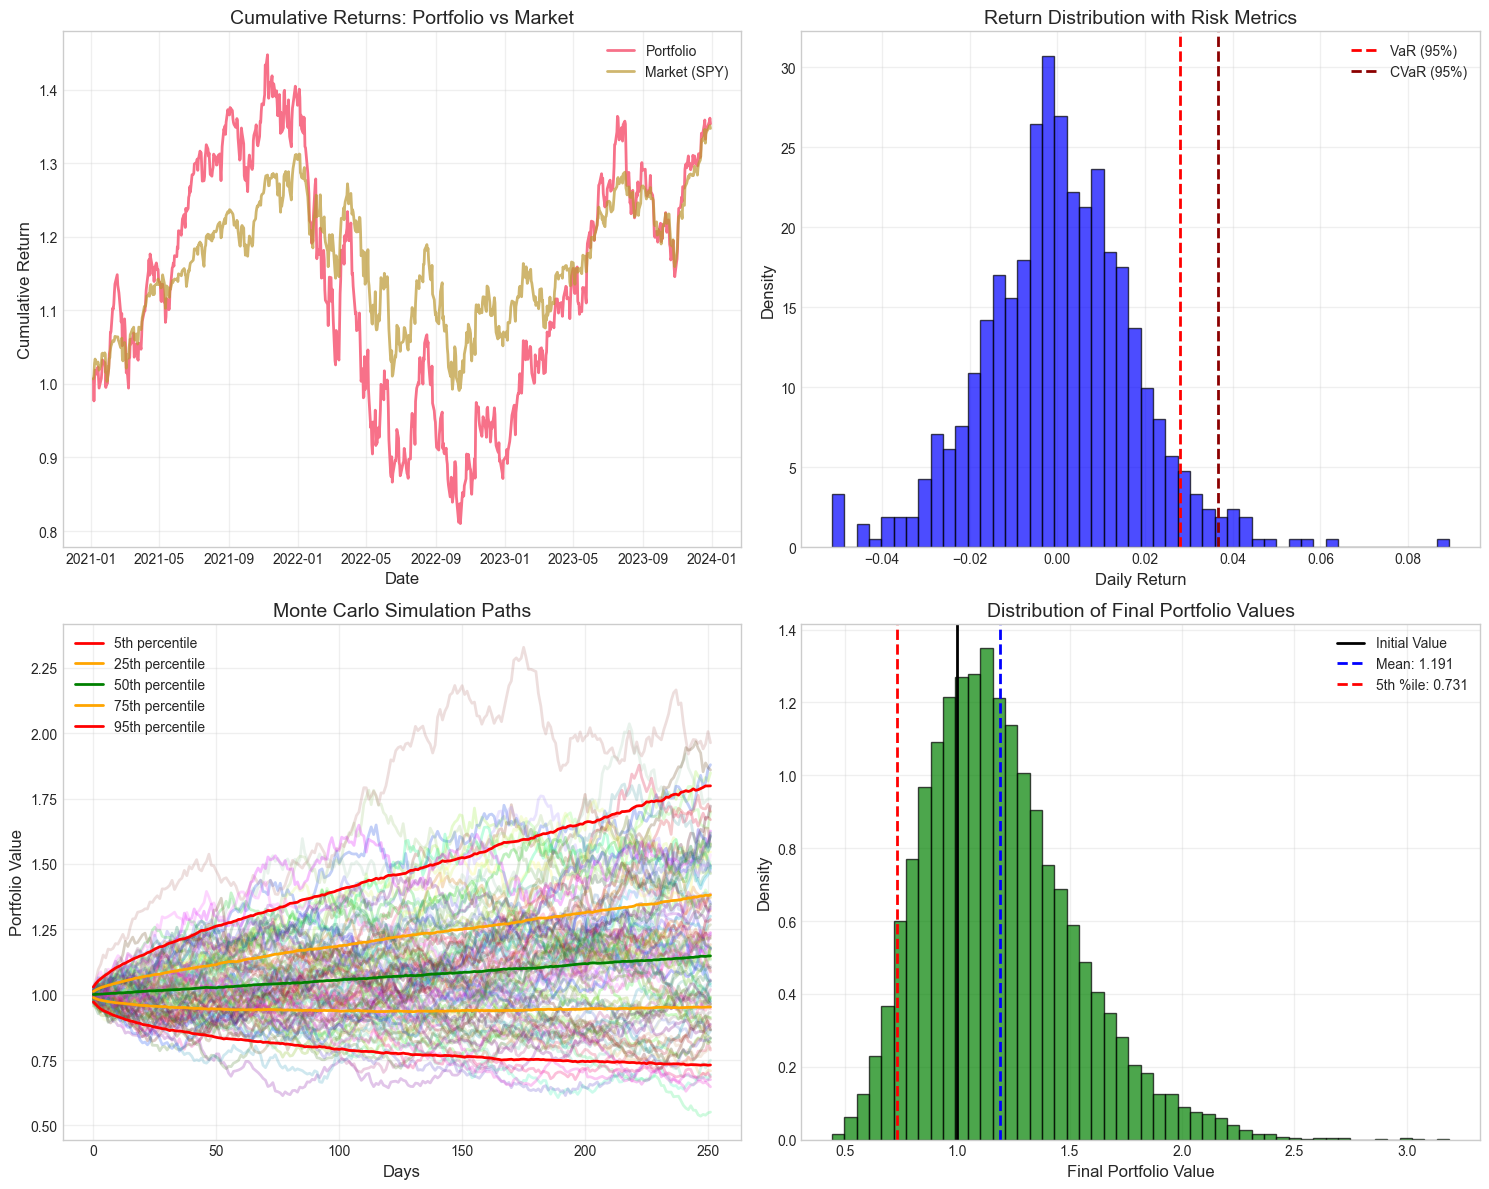

In [70]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Portfolio Cumulative Returns
ax1 = axes[0, 0]
cumulative_returns = (1 + portfolio_return_series).cumprod()
market_cumulative = (1 + market_returns).cumprod()
ax1.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', linewidth=2)
ax1.plot(market_cumulative.index, market_cumulative, label='Market (SPY)', linewidth=2, alpha=0.7)
ax1.set_title('Cumulative Returns: Portfolio vs Market', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Return Distribution with VaR and CVaR
ax2 = axes[0, 1]
ax2.hist(portfolio_return_series, bins=50, alpha=0.7, density=True, color='blue', edgecolor='black')
ax2.axvline(calculate_var_historical(portfolio_return_series, 0.95),
            color='red', linestyle='--', linewidth=2, label='VaR (95%)')
ax2.axvline(calculate_cvar(portfolio_return_series, 0.95),
            color='darkred', linestyle='--', linewidth=2, label='CVaR (95%)')
ax2.set_title('Return Distribution with Risk Metrics', fontsize=14)
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Monte Carlo Simulation Paths
ax3 = axes[1, 0]
# Plot a subset of simulation paths
paths_to_plot = 100

# Random RVB color for each path
for i in range(min(paths_to_plot, MC_SIMULATIONS)):
     random_color = np.random.rand(3,)
     ax3.plot(portfolio_values[:, i], alpha=0.25, color=random_color)

# Plot percentiles
percentiles = [5, 25, 50, 75, 95]
colors = ['red', 'orange', 'green', 'orange', 'red']

for p, color in zip(percentiles, colors):
    path = np.percentile(portfolio_values, p, axis=1)
    ax3.plot(path, color=color, linewidth=2, label=f'{p}th percentile')

ax3.set_title('Monte Carlo Simulation Paths', fontsize=14)
ax3.set_xlabel('Days')
ax3.set_ylabel('Portfolio Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Final Value Distribution
ax4 = axes[1, 1]
ax4.hist(final_values, bins=50, alpha=0.7, density=True, color='green', edgecolor='black')
ax4.axvline(1, color='black', linestyle='-', linewidth=2, label='Initial Value')
ax4.axvline(mean_final_value, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_final_value:.3f}')
ax4.axvline(percentile_5, color='red', linestyle='--', linewidth=2, label=f'5th %ile: {percentile_5:.3f}')
ax4.set_title('Distribution of Final Portfolio Values', fontsize=14)
ax4.set_xlabel('Final Portfolio Value')
ax4.set_ylabel('Density')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Risk Analysis and Correlation

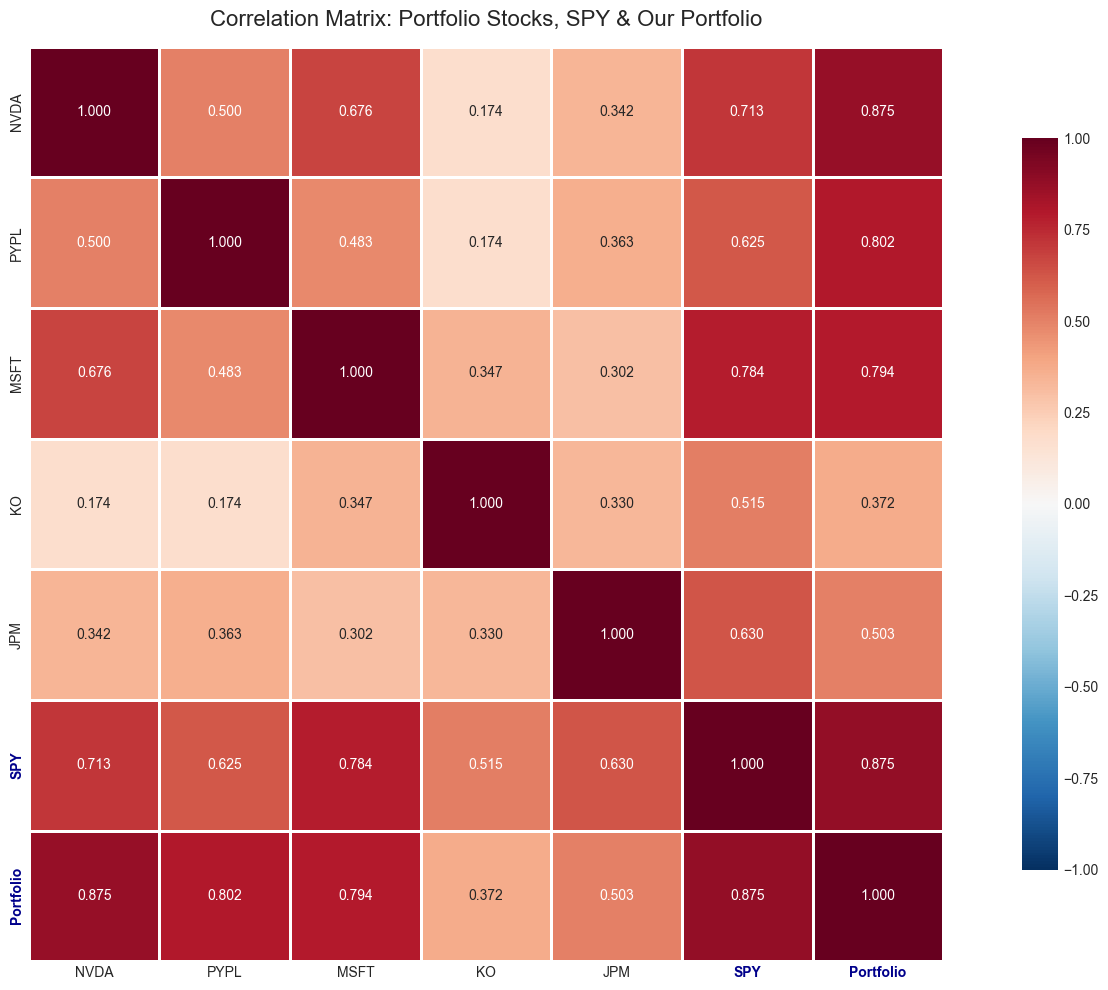

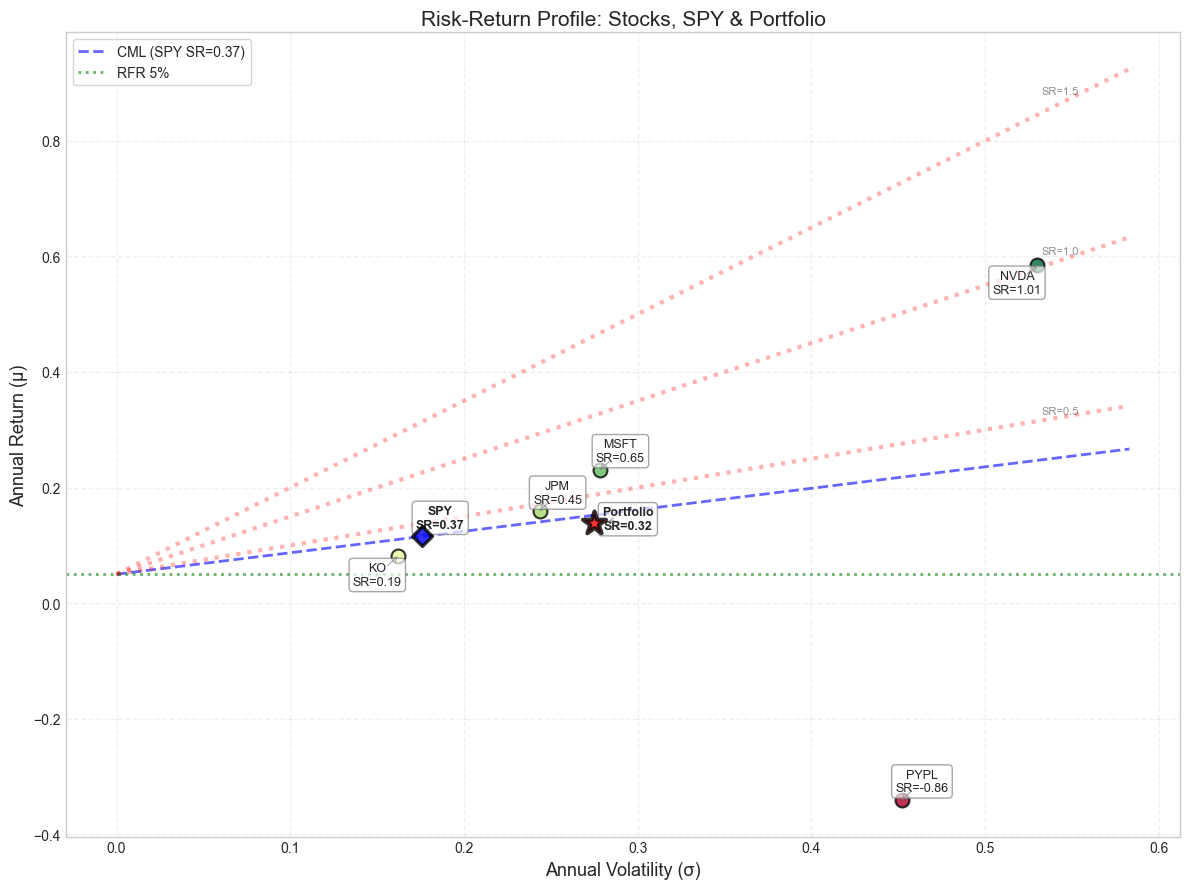

| Asset     | Return   | Risk   |   Sharpe | vs SPY   |
|-----------|----------|--------|----------|----------|
| NVDA      | 58.47%   | 53.00% |     1.01 | +46.92%  |
| PYPL      | -34.08%  | 45.19% |    -0.86 | -45.62%  |
| MSFT      | 23.08%   | 27.83% |     0.65 | +11.54%  |
| KO        | 8.08%    | 16.18% |     0.19 | -3.46%   |
| JPM       | 15.91%   | 24.36% |     0.45 | +4.37%   |
| SPY       | 11.54%   | 17.60% |     0.37 | +0.00%   |
| PORTFOLIO | 13.92%   | 27.50% |     0.32 | +2.38%   |


In [72]:
# =============================================================================
# ENHANCED CORRELATION AND RISK-RETURN ANALYSIS
# =============================================================================

# --- 0. Pre-req: portfolio_return_series -------------------------------------
# (Assumes you have `weights` for your stocks and `portfolio_returns` DF)
portfolio_return_series = portfolio_returns.dot(weights) \
    .rename("Portfolio")


# --- 1. Enhanced Correlation Matrix (now includes Portfolio & SPY) ------------
plt.figure(figsize=(16, 10))

# Combine all the returns
combined_returns = pd.concat(
    [portfolio_returns,
     market_returns.rename("SPY"),
     portfolio_return_series],
    axis=1
)
corr = combined_returns.corr()

# Draw heatmap
sns.heatmap(corr,
            annot=True, fmt=".3f",
            cmap="RdBu_r", center=0,
            square=True, linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title("Correlation Matrix: Portfolio Stocks, SPY & Our Portfolio", fontsize=16, pad=15)

# Highlight SPY & Portfolio labels
ax = plt.gca()
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    if lbl.get_text() in ("SPY", "Portfolio"):
        lbl.set_weight("bold")
        lbl.set_color("darkblue")

plt.tight_layout()
plt.show()


# --- 2. Risk‐Return Scatter Plot with automatic label adjustment ----------
plt.figure(figsize=(12, 9))

# Recompute these if you haven’t already
TRADING_DAYS = 252
all_ret = combined_returns.mean() * TRADING_DAYS
all_vol = combined_returns.std() * np.sqrt(TRADING_DAYS)
sharpe  = (all_ret - RISK_FREE_RATE) / all_vol

# colormap
norm = plt.Normalize(sharpe.min(), sharpe.max())
cmap = plt.cm.RdYlGn

texts = []
for asset in combined_returns.columns:
    vol = all_vol[asset]
    ret = all_ret[asset]
    sr  = sharpe[asset]

    # marker styling
    if asset == "SPY":
        marker, size = "D", 100
        color = "blue"
        ec, lw = "black", 2.5
    elif asset == "Portfolio":
        marker, size = "*", 300
        color = "red"
        ec, lw = "black", 3
    else:
        marker, size = "o", 100
        color = cmap(norm(sr))
        ec, lw = "black", 1.5

    plt.scatter(vol, ret,
                s=size,
                c=[color],
                marker=marker,
                edgecolors=ec,
                linewidth=lw,
                alpha=0.8,
                zorder=3 if asset not in ("SPY","Portfolio") else 4)

    # create TEXT objects (not direct annotate)
    txt = plt.text(vol, ret,
                   f"{asset}\nSR={sr:.2f}",
                   fontsize=9,
                   weight="bold" if asset in ("SPY","Portfolio") else "normal",
                   ha="center", va="center",
                   bbox=dict(boxstyle="round,pad=0.3",
                             facecolor="white", alpha=0.7,
                             edgecolor="gray"))
    texts.append(txt)

# Capital Market Line, Sharpe‐ratio lines, RFR unchanged...
x_max = max(all_vol.max(), all_vol["Portfolio"]) * 1.1
x_cml = np.linspace(0, x_max, 100)
spy_sr = sharpe["SPY"]
y_cml = RISK_FREE_RATE + spy_sr * x_cml
plt.plot(x_cml, y_cml, "b--", lw=2, alpha=0.6, label=f"CML (SPY SR={spy_sr:.2f})")
for sr in (0.5, 1.0, 1.5):
    y = RISK_FREE_RATE + sr * x_cml
    plt.plot(x_cml, y, "red", linestyle=":", lw=3, alpha=0.3)
    plt.text(x_max*0.95, RISK_FREE_RATE+sr*x_max*0.95,
             f"SR={sr}", ha="right", fontsize=8, alpha=0.5)

plt.axhline(RISK_FREE_RATE, linestyle=":", color="green", alpha=0.6,
            label=f"RFR {RISK_FREE_RATE:.0%}")

plt.xlabel("Annual Volatility (σ)", fontsize=13)
plt.ylabel("Annual Return (μ)", fontsize=13)
plt.title("Risk-Return Profile: Stocks, SPY & Portfolio", fontsize=15)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="upper left", frameon=True)

# <<< Push labels apart and add arrows >>>
ax = plt.gca()   # grab the current axes

adjust_text(
    texts,
    ax=ax,
    only_move={'points':'y', 'texts':'y'},
    # Here modifications are allowed
    arrowprops=dict(
        arrowstyle='->',
        color='gray',
        lw=0.5,
        shrinkA=10,   # Try ton increase this value (ex: 10)
        shrinkB=10    # Try ton increase this value  (ex: 10)
    ),
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_text=0.5,
    force_points=0.2,
)

plt.tight_layout()
plt.show()

# --- 3. Print Summary Table ----------------------------------------------
from tabulate import tabulate

# 3.1) Extract portfolio metrics directly from the computed series
portfolio_annual_return = all_ret["Portfolio"]
portfolio_annual_vol    = all_vol["Portfolio"]
portfolio_sharpe        = sharpe["Portfolio"]

# 3.2) Build a DataFrame of pure floats
summary_df = pd.DataFrame({
    "Return": all_ret,
    "Risk":   all_vol,
    "Sharpe": sharpe
})

# 3.3) Compute “vs SPY” in the same units as Return
summary_df["vs SPY"] = summary_df["Return"] - summary_df.loc["SPY", "Return"]

# 3.4) Append the portfolio as its own float row
summary_df.loc["PORTFOLIO"] = [
    portfolio_annual_return,
    portfolio_annual_vol,
    portfolio_sharpe,
    portfolio_annual_return - summary_df.loc["SPY", "Return"]
]

# 3.5) Optionally reorder: stocks → SPY → PORTFOLIO
order = list(portfolio_returns.columns) + ["SPY", "PORTFOLIO"]
summary_df = summary_df.loc[order]

# 3.6) Prepare a printing copy and format columns exactly once
print_df = summary_df.copy()
print_df["Return"] = print_df["Return"].apply(lambda x: f"{x:.2%}")
print_df["Risk"]   = print_df["Risk"].apply(lambda x: f"{x:.2%}")
print_df["Sharpe"] = print_df["Sharpe"].apply(lambda x: f"{x:.2f}")
print_df["vs SPY"] = print_df["vs SPY"].apply(lambda x: f"{x:+.2%}")

# 3.7) Reset index to get “Asset” as a column
table = print_df.reset_index().rename(columns={"index": "Asset"})

# 3.8) Print a clean GitHub-style table with tabulate
print(tabulate(
    table,
    headers="keys",
    tablefmt="github",
    showindex=False
))

## Maximum Drawdown Analysis

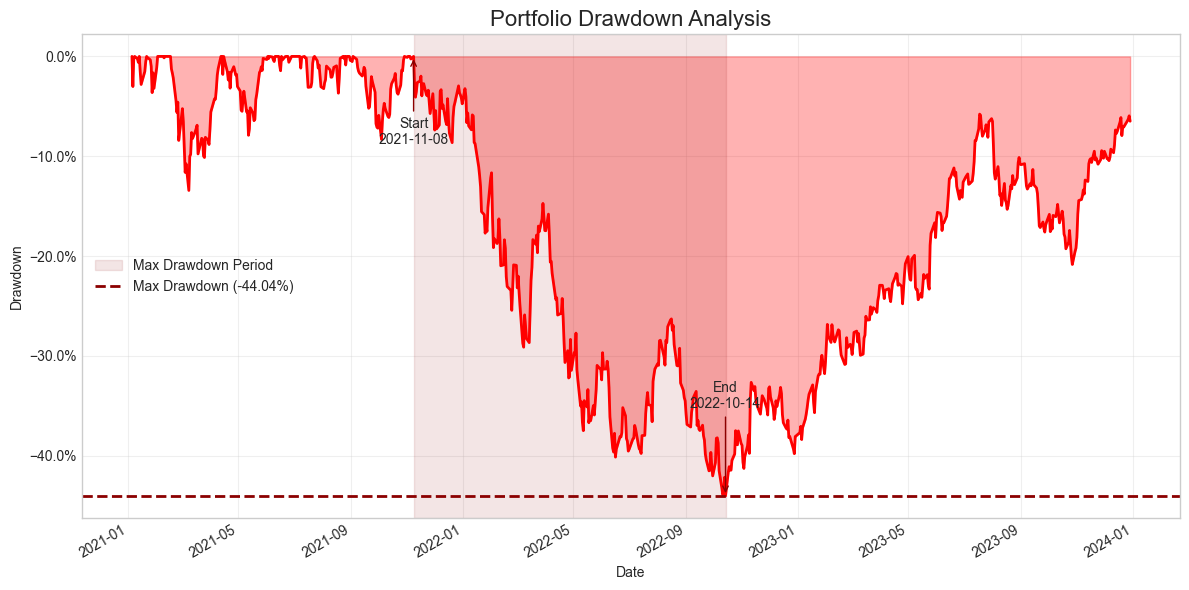

Maximum Drawdown: -44.04%
Drawdown Period: 2021-11-08 → 2022-10-14 (340 days)


In [40]:
def calculate_drawdown(returns):
    """Calculate drawdown series and maximum drawdown with dates."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max

    max_dd = drawdown.min()
    dd_end = drawdown.idxmin()
    dd_start = cumulative.loc[:dd_end].idxmax()
    return drawdown, max_dd, dd_start, dd_end

# Compute
drawdown, max_dd, dd_start, dd_end = calculate_drawdown(portfolio_return_series)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(drawdown.index, drawdown, color='red', linewidth=2)
ax.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)

# Highlight max drawdown period
ax.axvspan(dd_start, dd_end, color='darkred', alpha=0.1, label='Max Drawdown Period')
ax.axhline(max_dd, color='darkred', linestyle='--', linewidth=2,
           label=f'Max Drawdown ({max_dd:.2%})')

# Annotate start & end
ax.annotate('Start\n'+dd_start.strftime('%Y-%m-%d'),
            xy=(dd_start, 0), xytext=(dd_start, max_dd*0.2),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')
ax.annotate('End\n'+dd_end.strftime('%Y-%m-%d'),
            xy=(dd_end, max_dd), xytext=(dd_end, max_dd*0.8),
            arrowprops=dict(arrowstyle='->', color='darkred'),
            ha='center')

# Formatting axes
ax.set_title('Portfolio Drawdown Analysis', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Print summary
duration = (dd_end - dd_start).days
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Drawdown Period: {dd_start.date()} → {dd_end.date()} ({duration} days)")

## Summary Report


In [127]:
print("=" * 80)

# --- PORTFOLIO COMPOSITION -----------------------------------------------
comp_df = (
    pd.Series(PORTFOLIO, name="Weight")   # your dict of ticker→weight
      .mul(100)                           # convert to percent
      .round(1)                          # one decimal
      .astype(str)
      .add("%")                          # “25.0%”
      .to_frame()
      .reset_index()
      .rename(columns={"index":"Asset"})
)

print("\n📊 PORTFOLIO COMPOSITION")
print(tabulate(
    comp_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- PERFORMANCE METRICS -------------------------------------------------
perf_df = pd.DataFrame({
    "Metric": ["Ann. Return", "Ann. Volatility", "Max Drawdown"],
    "Value":  [annualized_return, annualized_volatility, max_drawdown]
})
perf_df["Value"] = perf_df["Value"].map("{:.2%}".format)

print("\n📈 PERFORMANCE METRICS")
print(tabulate(
    perf_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- RISK-ADJUSTED (CAPM) ------------------------------------------------
capm_df = (
    pd.DataFrame.from_dict(capm_metrics, orient="index", columns=["Value"])
      .round(3)
      .reset_index()
      .rename(columns={"index":"Metric"})
)

print("\n⚖️ RISK-ADJUSTED (CAPM) METRICS")
print(tabulate(
    capm_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- ANNUAL RISK METRICS (VaR & CVaR) -------------------------------------
risk_rows = []
for α in CONFIDENCE_LEVELS:
    v = calculate_var_historical(portfolio_return_series, α) * np.sqrt(TRADING_DAYS)
    c = calculate_cvar(portfolio_return_series, α)       * np.sqrt(TRADING_DAYS)
    risk_rows.append((f"VaR {α:.0%}",  f"{v:.2%}"))
    risk_rows.append((f"CVaR {α:.0%}", f"{c:.2%}"))

risk_df = pd.DataFrame(risk_rows, columns=["Metric","Value"])

print("\n🛑 ANNUAL RISK METRICS")
print(tabulate(
    risk_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))


# --- MONTE CARLO FORECAST (1-yr) -----------------------------------------
mc_df = pd.DataFrame({
    "Metric": ["Expected Value","5th Percentile","95th Percentile","Prob of Gain"],
    "Value" : [mean_final_value, percentile_5, percentile_95, (final_values>1).mean()]
})

# Mix numeric and percentage formats
def fmt_mc(row):
    if row.name == 0 or row.name == 2:
        return f"{row.Value:.3f}"
    else:
        return f"{row.Value:.1%}"

mc_df["Value"] = mc_df.apply(fmt_mc, axis=1)

print("\n🔮 MONTE CARLO FORECAST (1 YR)")
print(tabulate(
    mc_df,
    headers="keys",
    tablefmt="github",
    showindex=False
))

print("\n" + "=" * 80)



📊 PORTFOLIO COMPOSITION
| Asset   | Weight   |
|---------|----------|
| NVDA    | 25.0%    |
| PYPL    | 25.0%    |
| MSFT    | 20.0%    |
| KO      | 20.0%    |
| JPM     | 10.0%    |

📈 PERFORMANCE METRICS
| Metric          | Value   |
|-----------------|---------|
| Ann. Return     | 13.92%  |
| Ann. Volatility | 27.50%  |
| Max Drawdown    | -44.04% |

⚖️ RISK-ADJUSTED (CAPM) METRICS
| Metric            |   Value |
|-------------------|---------|
| Beta              |   1.368 |
| Sharpe Ratio      |   0.324 |
| Treynor Ratio     |   0.065 |
| Jensen's Alpha    |  -0     |
| Information Ratio |   0.161 |
| Sortino Ratio     |   0.51  |

🛑 ANNUAL RISK METRICS
| Metric   | Value   |
|----------|---------|
| VaR 95%  | 44.36%  |
| CVaR 95% | 58.30%  |
| VaR 99%  | 70.88%  |
| CVaR 99% | 78.53%  |

🔮 MONTE CARLO FORECAST (1 YR)
| Metric          | Value   |
|-----------------|---------|
| Expected Value  | 1.191   |
| 5th Percentile  | 73.1%   |
| 95th Percentile | 1.799   |
| Prob of 